# Narrative Analysis - News vs Community Channels

This notebook analyzes propaganda narratives shared between news and community Telegram channels.

Key questions addressed:
1. Do news and community channels share similar narratives?
2. Is content directly forwarded from news channels to community channels?
3. Do certain narratives appear in community channels after appearing in news channels?

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import math
from sqlalchemy import create_engine

# For prettier visualizations
plt.style.use('ggplot')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

## Database Connection and Constants

In [3]:
# Database connection settings
CONNECTION_STRING = 'postgresql+psycopg2://kiliansprenkamp@localhost:5432/telegram_scraper'
ENGINE = create_engine(CONNECTION_STRING)

# Narrative columns (exact names from database)
NARRATIVE_COLUMNS = [
    'denazificationofukraine__similarity',
    'protectionofrussianspeakers__similarity',
    'natoexpansionthreat__similarity',
    'biolabsconspiracy__similarity',
    'ukraineasafailedstate__similarity',
    'historicalunityofrussiaandukraine__similarity',
    'westernrussophobia__similarity',
    'sanctionsaseconomicwarfare__similarity',
    'legitimizationofannexedterritories__similarity',
    'discreditingukrainianleadership__similarity'
]

# Prettier display names (for plots/output)
NARRATIVE_DISPLAY_NAMES = {
    'denazificationofukraine__similarity': "Denazification of Ukraine",
    'protectionofrussianspeakers__similarity': "Protection of Russian Speakers",
    'natoexpansionthreat__similarity': "NATO Expansion Threat",
    'biolabsconspiracy__similarity': "Biolabs Conspiracy",
    'ukraineasafailedstate__similarity': "Ukraine as a Failed State",
    'historicalunityofrussiaandukraine__similarity': "Historical Unity",
    'westernrussophobia__similarity': "Western Russophobia",
    'sanctionsaseconomicwarfare__similarity': "Sanctions as Economic Warfare",
    'legitimizationofannexedterritories__similarity': "Legitimization of Annexed Territories",
    'discreditingukrainianleadership__similarity': "Discrediting Ukrainian Leadership"
}

## Data Loading Functions

In [4]:
def load_table_in_chunks(table_name, columns="*", condition=None, description=None, chunk_size=250000):
    """Load a table in chunks with a progress bar"""
    query = f"SELECT {columns} FROM {table_name}"
    if condition:
        query += f" WHERE {condition}"
    
    # Get total count first
    with ENGINE.connect() as conn:
        count_query = f"SELECT COUNT(*) as count FROM ({query}) as subquery"
        total_rows = pd.read_sql_query(count_query, conn).iloc[0]['count']
    
    # Load in chunks
    chunks = []
    num_chunks = math.ceil(total_rows / chunk_size)
    
    with tqdm(total=total_rows, desc=description or f"Loading {table_name}") as pbar:
        for i in range(num_chunks):
            offset = i * chunk_size
            chunk_query = f"{query} LIMIT {chunk_size} OFFSET {offset}"
            
            with ENGINE.connect() as conn:
                chunk = pd.read_sql_query(chunk_query, conn)
            
            chunks.append(chunk)
            pbar.update(len(chunk))
    
    return pd.concat(chunks, ignore_index=True) if chunks else pd.DataFrame()

## Check Available Tables

In [5]:
# Check which tables are available in the database
with ENGINE.connect() as conn:
    # Query to get all tables in our database
    tables_query = "SELECT table_name FROM information_schema.tables WHERE table_schema='public'"
    available_tables = pd.read_sql_query(tables_query, conn)['table_name'].tolist()
    
print(f"Available tables in database: {available_tables}")

Available tables in database: ['messages_news', 'messages_community', 'messages_community_debug', 'classified_messages_community', 'classified_messages_news', 'messages_community_with_bot_status']


## Load Classified Message Data

In [6]:
community_df = load_table_in_chunks('classified_messages_community', 
                                   description="Loading classified community messages")

# Load classified news messages
news_df = load_table_in_chunks('classified_messages_news',
                              description="Loading classified news messages")

Loading classified news messages: 100%|██████████| 2201902/2201902 [00:32<00:00, 68137.33it/s]


## Load Forwarding Information

In [7]:
# Now load the original message tables to get forwarding information
forwarding_data_loaded = False

if 'messages_community' in available_tables:
    print("\nLoading forwarding data from original message tables...")
    
    # For community messages, select all columns except embedding_user_bge_m3_32_bits
    community_cols = "id, chat_id, chat_name, peer_id, messagedatetime, messagedate, messagetext, out, mentioned, media_unread, silent, post, from_scheduled, legacy, edit_hide, pinned, noforwards, invert_media, offline, from_id, from_boosts_applied, saved_peer_id, fwd_from, fwd_from_type, via_bot_id, via_business_bot_id, reply_to, reply_markup, entities, edit_date, post_author, grouped_id, ttl_period, quick_reply_shortcut_id, effect, factcheck, views, forwards, replies, reactions"
    
    community_msgs = load_table_in_chunks(
        'messages_community',
        columns=community_cols,
        # condition=community_condition,
        description="Loading raw community messages"
    )
    
    # For news messages, also exclude embedding column
    news_cols = "id, chat_id, chat_name, peer_id, messagedatetime, messagedate, messagetext, out, mentioned, media_unread, silent, post, from_scheduled, legacy, edit_hide, pinned, noforwards, invert_media, offline, from_id, from_boosts_applied, saved_peer_id, fwd_from, fwd_from_type, via_bot_id, via_business_bot_id, reply_to, reply_markup, entities, edit_date, post_author, grouped_id, ttl_period, quick_reply_shortcut_id, effect, factcheck, views, forwards, replies, reactions"
    
    news_msgs = load_table_in_chunks(
        'messages_news',
        columns=news_cols,
        description="Loading raw news messages"
    )
    
    # Check if we have the forwarding columns
    if 'fwd_from' in community_msgs.columns and 'peer_id' in news_msgs.columns:
        print("Successfully loaded forwarding information")
        
        # Merge the forwarding information into the classified dataframes
        # Add a join key to both dataframes
        community_df['join_key'] = community_df['chat_id'].astype(str) + '_' + community_df['id'].astype(str)
        community_msgs['join_key'] = community_msgs['chat_id'].astype(str) + '_' + community_msgs['id'].astype(str)
        
        news_df['join_key'] = news_df['chat_id'].astype(str) + '_' + news_df['id'].astype(str)
        news_msgs['join_key'] = news_msgs['chat_id'].astype(str) + '_' + news_msgs['id'].astype(str)
        
        # Merge the forwarding information
        if 'fwd_from' in community_msgs.columns:
            community_df = pd.merge(
                community_df,
                community_msgs[['join_key', 'fwd_from']],
                on='join_key',
                how='left'
            )
            
        if 'peer_id' in news_msgs.columns:
            news_df = pd.merge(
                news_df,
                news_msgs[['join_key', 'peer_id']],
                on='join_key',
                how='left'
            )
            
        # Drop the temporary join key
        community_df.drop('join_key', axis=1, inplace=True)
        news_df.drop('join_key', axis=1, inplace=True)
        
        forwarding_data_loaded = True
    else:
        print("Missing forwarding columns in raw message tables")
else:
    print("Original message tables not found - cannot load forwarding information")


Loading forwarding data from original message tables...


Loading raw community messages: 100%|██████████| 3073946/3073946 [00:40<00:00, 76525.77it/s]
/var/folders/jx/2l7p1chd2l7djbz_8s3s_4z80000gn/T/ipykernel_2555/3041784144.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(chunks, ignore_index=True) if chunks else pd.DataFrame()
Loading raw news messages: 100%|██████████| 1100978/1100978 [00:35<00:00, 30997.92it/s]


Successfully loaded forwarding information


In [ ]:
#remove all  duplicates in each df
community_df = community_df.drop_duplicates()
news_df = news_df.drop_duplicates()
# print shape of each df
print(community_df.shape)
print(news_df.shape)


## Process Data

In [ ]:
# Convert datetime columns
print("\nConverting datetime columns...")
community_df['messagedatetime'] = pd.to_datetime(community_df['messagedatetime'])
news_df['messagedatetime'] = pd.to_datetime(news_df['messagedatetime'])

# Print summary info
print(f"Loaded {len(community_df)} community messages from {community_df['messagedatetime'].min()} to {community_df['messagedatetime'].max()}")
print(f"Loaded {len(news_df)} news messages from {news_df['messagedatetime'].min()} to {news_df['messagedatetime'].max()}")
print(f"Forwarding information loaded: {forwarding_data_loaded}")

# Verify narrative columns exist
missing_narratives_community = []
missing_narratives_news = []

for col in NARRATIVE_COLUMNS:
    if col not in community_df.columns:
        missing_narratives_community.append(col)
    if col not in news_df.columns:
        missing_narratives_news.append(col)

if missing_narratives_community:
    print(f"WARNING: {len(missing_narratives_community)} columns missing from community data")
    
if missing_narratives_news:
    print(f"WARNING: {len(missing_narratives_news)} columns missing from news data")

## Add Week Column for Analysis

In [10]:
# Add week column for temporal analysis
community_df['week'] = community_df['messagedatetime'].dt.to_period('W')
news_df['week'] = news_df['messagedatetime'].dt.to_period('W')

## Find Messages with Strong Narrative Signals

In [ ]:
def find_messages_with_narratives(df, threshold=0.6):
    """Find messages with strong narrative signals"""
    print(f"\nFinding messages with narratives (threshold > {threshold})...")
    
    # Dictionary to store messages by narrative
    narrative_messages = {}
    
    # Count total messages per narrative
    total_counts = {}
    
    for narrative in NARRATIVE_COLUMNS:
        if narrative not in df.columns:
            print(f"Skipping {narrative} - not found in data")
            continue
            
        # Get messages with strong signal for this narrative
        matches = df[df[narrative] > threshold]
        narrative_messages[narrative] = matches
        total_counts[narrative] = len(matches)
        
        # Print summary
        display_name = NARRATIVE_DISPLAY_NAMES.get(narrative, narrative)
        print(f"  {display_name}: {len(matches)} messages")
        
        # Show sample of top messages
        if len(matches) > 0:
            top_examples = matches.sort_values(narrative, ascending=False).head(1)
            for _, row in top_examples.iterrows():
                score = row[narrative]
                text_preview = row['messagetext'][:100] + "..." if len(row['messagetext']) > 100 else row['messagetext']
                print(f"    Top example (score: {score:.4f}): {text_preview}")
    
    # Print overall summary
    total_narratives = sum(total_counts.values())
    total_unique = df[df[NARRATIVE_COLUMNS].gt(threshold).any(axis=1)].shape[0]
    print(f"\nFound {total_narratives} narrative instances across {total_unique} unique messages")
    
    return narrative_messages, total_counts

# Find messages with narratives in both datasets
community_narratives, community_counts = find_messages_with_narratives(community_df)
news_narratives, news_counts = find_messages_with_narratives(news_df)

## Compare Narrative Prevalence

In [ ]:
print("\nComparing narrative prevalence:")

# Create side-by-side bar chart
plt.figure(figsize=(14, 8))

# Prepare data for plotting
narratives = []
community_values = []
news_values = []

for narrative in NARRATIVE_COLUMNS:
    if narrative in community_counts and narrative in news_counts:
        display_name = NARRATIVE_DISPLAY_NAMES.get(narrative, narrative)
        narratives.append(display_name)
        community_values.append(community_counts[narrative])
        news_values.append(news_counts[narrative])

# Create bar positions
x = np.arange(len(narratives))
width = 0.35

# Create bars
plt.bar(x - width/2, community_values, width, label='Community')
plt.bar(x + width/2, news_values, width, label='News')

# Add labels and title
plt.xlabel('Narrative')
plt.ylabel('Number of Messages')
plt.title('Narrative Prevalence: News vs Community')
plt.xticks(x, narratives, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('narrative_prevalence_comparison.png')
plt.show()

## Calculate Percentage of Messages with Each Narrative

In [ ]:
# Calculate percentage of messages with each narrative
community_pct = {narrative: count / len(community_df) * 100 
                for narrative, count in community_counts.items()}
news_pct = {narrative: count / len(news_df) * 100 
           for narrative, count in news_counts.items()}

# Print percentages
print("\nPercentage of messages with each narrative:")
for narrative in NARRATIVE_COLUMNS:
    if narrative in community_pct and narrative in news_pct:
        display_name = NARRATIVE_DISPLAY_NAMES.get(narrative, narrative)
        print(f"  {display_name}: Community {community_pct[narrative]:.2f}% vs News {news_pct[narrative]:.2f}%")

# Create a bar chart of percentages
plt.figure(figsize=(14, 8))

# Prepare data for plotting
narratives = []
community_pct_values = []
news_pct_values = []

for narrative in NARRATIVE_COLUMNS:
    if narrative in community_pct and narrative in news_pct:
        display_name = NARRATIVE_DISPLAY_NAMES.get(narrative, narrative)
        narratives.append(display_name)
        community_pct_values.append(community_pct[narrative])
        news_pct_values.append(news_pct[narrative])

# Create bar positions
x = np.arange(len(narratives))
width = 0.35

# Create bars
plt.bar(x - width/2, community_pct_values, width, label='Community')
plt.bar(x + width/2, news_pct_values, width, label='News')

# Add labels and title
plt.xlabel('Narrative')
plt.ylabel('Percentage of Messages (%)')
plt.title('Narrative Prevalence (Percentage): News vs Community')
plt.xticks(x, narratives, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.savefig('narrative_prevalence_percentage.png')
plt.show()

## Analyze Temporal Patterns

In [ ]:
def analyze_temporal_patterns(community_narratives, news_narratives):
      """Analyze how narratives evolve over time in both datasets"""
      print("\nAnalyzing temporal patterns of narratives...")

      # Convert to weekly counts for better visualization
      weekly_data = {}

      for narrative in NARRATIVE_COLUMNS:
          if (narrative not in community_narratives) or (narrative not in news_narratives):
              print(f"Skipping {narrative} - not found in both datasets")
              continue

          # Get message counts by week
          community_counts = community_narratives[narrative].groupby('week').size()
          news_counts = news_narratives[narrative].groupby('week').size()

          # Sort the Series by index (week)
          community_counts = community_counts.sort_index()
          news_counts = news_counts.sort_index()

          # Store in dict for easy access
          weekly_data[narrative] = {
              'community': community_counts,
              'news': news_counts
          }

          # Generate visualization
          display_name = NARRATIVE_DISPLAY_NAMES.get(narrative, narrative)

          plt.figure(figsize=(14, 8))

          # Convert Period index to datetime for proper ordering on x-axis
          community_weeks = [pd.Period(p).to_timestamp() for p in community_counts.index]
          news_weeks = [pd.Period(p).to_timestamp() for p in news_counts.index]

          plt.plot(community_weeks, community_counts.values, 'r-', label='Community')
          plt.plot(news_weeks, news_counts.values, 'b-', label='News')

          plt.title(f"Weekly Message Count: {display_name}")
          plt.xlabel("Month")
          plt.ylabel("Number of Messages")

          # Format x-axis with month formatter
          from matplotlib.dates import DateFormatter
          date_format = DateFormatter('%B %Y')  # Month Year format
          plt.gca().xaxis.set_major_formatter(date_format)

          plt.xticks(rotation=45)

          # Show one label per month
          ax = plt.gca()
          
          # Get all unique months from the data
          all_dates = sorted(set(community_weeks + news_weeks))
          month_starts = []
          current_month = None
          
          for date in all_dates:
              if current_month != date.strftime('%Y-%m'):
                  current_month = date.strftime('%Y-%m')
                  month_starts.append(date)
          
          plt.xticks(month_starts)

          plt.legend()
          plt.tight_layout()
          plt.savefig(f"narrative_{display_name.replace(' ', '_')}.png")
          plt.show()

      return weekly_data

weekly_data = analyze_temporal_patterns(community_narratives, news_narratives)

## Analyze Forwarded Content (if available)

In [ ]:
# Try to analyze forwarded messages (will fall back to content overlap if columns missing)
try:
    if forwarding_data_loaded and 'fwd_from' in community_df.columns and 'peer_id' in news_df.columns:
        print("\nAnalyzing forwarded messages...")
        
        # Create mapping from peer_id to chat_name
        peer_to_chat = news_df[['peer_id', 'chat_name']].drop_duplicates().set_index('peer_id')['chat_name'].to_dict()
        
        # Map source channels for community messages
        community_df['source_channel'] = community_df['fwd_from'].map(peer_to_chat).fillna('unknown')
        
        # Get news channel names
        news_channels = set(news_df['chat_name'].unique())
        
        # Find forwards from news channels
        forwards = community_df[community_df['source_channel'].isin(news_channels)]
        
        print(f"Found {len(forwards)} messages forwarded from news to community channels")
        
        if len(forwards) > 0:
            # Check which narratives are present in forwarded messages
            forward_counts = {}
            for narrative in NARRATIVE_COLUMNS:
                if narrative not in forwards.columns:
                    continue
                
                matches = forwards[forwards[narrative] > 0.6]
                forward_counts[narrative] = len(matches)
                
                display_name = NARRATIVE_DISPLAY_NAMES.get(narrative, narrative)
                print(f"  {display_name}: {len(matches)} forwarded messages")
            
            # Get top source channels
            top_sources = forwards['source_channel'].value_counts().head(10)
            print("\nTop news sources forwarded to community channels:")
            for source, count in top_sources.items():
                print(f"  {source}: {count} messages")
                
            # Plot comparative narrative strength for forwarded vs. non-forwarded messages
            print("\nComparing narrative strength in forwarded vs. non-forwarded messages...")
            
            # Get non-forwarded messages
            non_forwarded = community_df[~community_df.index.isin(forwards.index)]
            
            # Calculate average strength for each narrative
            forwarded_avg = {narrative: forwards[narrative].mean() 
                            for narrative in NARRATIVE_COLUMNS if narrative in forwards.columns}
            non_forwarded_avg = {narrative: non_forwarded[narrative].mean() 
                                for narrative in NARRATIVE_COLUMNS if narrative in non_forwarded.columns}
            
            # Create plot
            plt.figure(figsize=(14, 8))
            
            # Prepare data
            plot_narratives = []
            forwarded_values = []
            non_forwarded_values = []
            
            for narrative in NARRATIVE_COLUMNS:
                if narrative in forwarded_avg and narrative in non_forwarded_avg:
                    display_name = NARRATIVE_DISPLAY_NAMES.get(narrative, narrative)
                    plot_narratives.append(display_name)
                    forwarded_values.append(forwarded_avg[narrative])
                    non_forwarded_values.append(non_forwarded_avg[narrative])
            
            # Create bar positions
            x = np.arange(len(plot_narratives))
            width = 0.35
            
            # Create bars
            plt.bar(x - width/2, forwarded_values, width, label='Forwarded Messages')
            plt.bar(x + width/2, non_forwarded_values, width, label='Non-Forwarded Messages')
            
            # Add labels and title
            plt.xlabel('Narrative')
            plt.ylabel('Average Similarity Score')
            plt.title('Narrative Strength: Forwarded vs. Non-Forwarded Messages')
            plt.xticks(x, plot_narratives, rotation=45, ha='right')
            plt.legend()
            plt.tight_layout()
            plt.savefig('narrative_forwarded_comparison.png')
            plt.show()
    else:
        print("\nSkipping forwarded messages analysis - required columns not available")
except Exception as e:
    print(f"Error analyzing forwarded messages: {e}")

In [ ]:
try:
    if forwarding_data_loaded and 'fwd_from' in community_df.columns and 'peer_id' in news_df.columns:
        print("\nAnalyzing forwarded messages...")

        # Create mapping from peer_id to chat_name, handling potential duplicates
        # First check if there are duplicate peer_ids
        peer_id_counts = news_df['peer_id'].value_counts()
        duplicate_peer_ids = peer_id_counts[peer_id_counts > 1].index.tolist()

        if duplicate_peer_ids:
            print(f"Found {len(duplicate_peer_ids)} duplicate peer_ids in news data. Using first occurrence for each.")
            # Keep only the first occurrence of each peer_id for the mapping
            peer_id_mapping_df = news_df[['peer_id', 'chat_name']].drop_duplicates(subset=['peer_id'], keep='first')
            peer_to_chat = dict(zip(peer_id_mapping_df['peer_id'], peer_id_mapping_df['chat_name']))
        else:
            # No duplicates, proceed as normal
            peer_to_chat = dict(zip(news_df['peer_id'], news_df['chat_name']))

        # Map source channels for community messages
        # Convert fwd_from to appropriate type if needed
        if community_df['fwd_from'].dtype != news_df['peer_id'].dtype:
            print(f"Converting fwd_from type from {community_df['fwd_from'].dtype} to {news_df['peer_id'].dtype}")
            community_df['fwd_from'] = community_df['fwd_from'].astype(news_df['peer_id'].dtype)

        # Apply mapping
        community_df['source_channel'] = community_df['fwd_from'].map(lambda x: peer_to_chat.get(x, 'unknown'))

        # Get news channel names
        news_channels = set(news_df['chat_name'].unique())

        # Find forwards from news channels
        forwards = community_df[community_df['source_channel'].isin(news_channels)]
        print(f"Found {len(forwards)} messages forwarded from news to community channels")

        if len(forwards) > 0:
            # Check which narratives are present in forwarded messages
            forward_counts = {}
            for narrative in NARRATIVE_COLUMNS:
                if narrative not in forwards.columns:
                    continue
                matches = forwards[forwards[narrative] > 0.5]
                forward_counts[narrative] = len(matches)
                display_name = NARRATIVE_DISPLAY_NAMES.get(narrative, narrative)
                print(f"  {display_name}: {len(matches)} forwarded messages")

            # Get top source channels
            top_sources = forwards['source_channel'].value_counts().head(10)
            print("\nTop news sources forwarded to community channels:")
            for source, count in top_sources.items():
                print(f"  {source}: {count} messages")

            # Plot comparative narrative strength for forwarded vs. non-forwarded messages
            print("\nComparing narrative strength in forwarded vs. non-forwarded messages...")

            # Get non-forwarded messages
            non_forwarded = community_df[~community_df.index.isin(forwards.index)]

            # Calculate average strength for each narrative
            forwarded_avg = {
                narrative: forwards[narrative].mean()
                for narrative in NARRATIVE_COLUMNS if narrative in forwards.columns
            }
            non_forwarded_avg = {
                narrative: non_forwarded[narrative].mean()
                for narrative in NARRATIVE_COLUMNS if narrative in non_forwarded.columns
            }

            # Create plot
            plt.figure(figsize=(14, 8))

            # Prepare data for plotting
            plot_narratives = []
            forwarded_values = []
            non_forwarded_values = []
            for narrative in NARRATIVE_COLUMNS:
                if narrative in forwarded_avg and narrative in non_forwarded_avg:
                    display_name = NARRATIVE_DISPLAY_NAMES.get(narrative, narrative)
                    plot_narratives.append(display_name)
                    forwarded_values.append(forwarded_avg[narrative])
                    non_forwarded_values.append(non_forwarded_avg[narrative])

            # Define bar positions and width
            x = np.arange(len(plot_narratives))
            width = 0.35

            # Create bars
            plt.bar(x - width / 2, forwarded_values, width, label='Forwarded Messages')
            plt.bar(x + width / 2, non_forwarded_values, width, label='Non-Forwarded Messages')

            # Add labels, title, and legend
            plt.xlabel('Narrative')
            plt.ylabel('Average Similarity Score')
            plt.title('Narrative Strength: Forwarded vs. Non-Forwarded Messages')
            plt.xticks(x, plot_narratives, rotation=45, ha='right')
            plt.legend()
            plt.tight_layout()
            plt.savefig('narrative_forwarded_comparison.png')
            plt.show()
    else:
        print("\nSkipping forwarded messages analysis - required columns not available")
except Exception as e:
    print(f"Error analyzing forwarded messages: {e}")
    # Print more diagnostic information
    if 'news_df' in locals() and 'peer_id' in news_df.columns:
        print(f"news_df peer_id column type: {news_df['peer_id'].dtype}")
        print(f"news_df peer_id uniqueness: {news_df['peer_id'].nunique()} unique values in {len(news_df['peer_id'])} total")
    if 'community_df' in locals() and 'fwd_from' in community_df.columns:
        print(f"community_df fwd_from column type: {community_df['fwd_from'].dtype}")
        print(f"community_df fwd_from non-null values: {community_df['fwd_from'].count()} out of {len(community_df)}")


## Analyze Content Overlap Between News and Community

In [ ]:
# Check for similar content using fuzzy matching
if 'messagetext' in community_df.columns and 'messagetext' in news_df.columns:
    try:
        from rapidfuzz import fuzz
        import numpy as np
        
        print("\nAnalyzing shared message content (90% similarity)...")
        
        # Use smaller subset for efficiency
        sample_size = min(5000, len(news_df))  # Reduced sample size due to computational intensity
        news_sample = news_df.sample(sample_size) if len(news_df) > sample_size else news_df
        community_sample = community_df.sample(sample_size) if len(community_df) > sample_size else community_df
        
        # Initialize containers for similar messages
        similar_pairs = []
        
        # Clean and prepare texts
        news_texts = news_sample['messagetext'].dropna().tolist()
        community_texts = community_sample['messagetext'].dropna().tolist()
        
        # Find similar messages using fuzzy matching
        similarity_threshold = 90  # 90% similarity threshold
        
        for i, news_text in enumerate(news_texts):
            if i % 100 == 0:  # Progress indicator
                print(f"Processing news message {i}/{len(news_texts)}...")
                
            for comm_text in community_texts:
                # Calculate similarity ratio
                similarity = fuzz.ratio(news_text, comm_text)
                
                if similarity >= similarity_threshold:
                    similar_pairs.append((news_text, comm_text, similarity))
        
        print(f"\nFound {len(similar_pairs)} message pairs with {similarity_threshold}% or higher similarity")
        
        if len(similar_pairs) > 0:
            # Show some examples of similar content
            print("\nExamples of similar content:")
            for news_text, comm_text, similarity in sorted(similar_pairs, key=lambda x: x[2], reverse=True)[:3]:
                print(f"Similarity: {similarity}%")
                print(f"News: {news_text[:150]}..." if len(news_text) > 150 else f"News: {news_text}")
                print(f"Community: {comm_text[:150]}..." if len(comm_text) > 150 else f"Community: {comm_text}")
                print()
            
            # Get messages that are part of similar pairs
            similar_news_texts = set(pair[0] for pair in similar_pairs)
            similar_comm_texts = set(pair[1] for pair in similar_pairs)
            
            similar_news = news_df[news_df['messagetext'].isin(similar_news_texts)]
            similar_community = community_df[community_df['messagetext'].isin(similar_comm_texts)]
            
            print(f"  News channels with similar content: {similar_news['chat_name'].nunique()}")
            print(f"  Community channels with similar content: {similar_community['chat_name'].nunique()}")
            
            # Check narrative prevalence in similar content
            print("\nNarrative prevalence in similar content:")
            for narrative in NARRATIVE_COLUMNS:
                if narrative in similar_community.columns and narrative in similar_news.columns:
                    # Count messages above threshold
                    community_matches = similar_community[similar_community[narrative] > 0.6].shape[0]
                    news_matches = similar_news[similar_news[narrative] > 0.6].shape[0]
                    
                    if community_matches > 0 or news_matches > 0:
                        display_name = NARRATIVE_DISPLAY_NAMES.get(narrative, narrative)
                        print(f"  {display_name}: {community_matches} community, {news_matches} news")
    except Exception as e:
        print(f"Error analyzing similar content: {e}")
        raise e  # Re-raise to see full traceback

In [ ]:
def analyze_channel_content_similarity():
    """Analyze the overall content similarity between news and community channels"""
    from rapidfuzz import fuzz
    import numpy as np
    import time
    
    print("\nAnalyzing content similarity between news and community channels...")
    
    # Sample messages for analysis
    sample_size = min(2000, len(news_df), len(community_df))
    news_sample = news_df.sample(sample_size)['messagetext'].dropna().tolist()
    community_sample = community_df.sample(sample_size)['messagetext'].dropna().tolist()
    
    # Calculate similarity distributions
    similarities = []
    total = len(news_sample)
    
    # Process each news message with simple progress indicator
    for i, news_msg in enumerate(news_sample):
        if i % 100 == 0:  # Show progress every 100 messages
            print(f"Processing: {i}/{total} messages ({(i/total*100):.1f}%)")
            
        # For each news message, get its highest similarity score with any community message
        msg_similarities = []
        for comm_msg in community_sample:
            similarity = fuzz.ratio(news_msg, comm_msg)
            msg_similarities.append(similarity)
        
        # Store the highest similarity score for this news message
        if msg_similarities:
            similarities.append(max(msg_similarities))
    
    print(f"Completed processing {total} messages")
    similarities = np.array(similarities)
    
    # Analyze similarity distribution
    print("\nSimilarity Distribution Analysis:")
    print(f"Average similarity score: {np.mean(similarities):.2f}%")
    print(f"Median similarity score: {np.median(similarities):.2f}%")
    print(f"Standard deviation: {np.std(similarities):.2f}%")
    
    # Calculate percentage of content at different similarity thresholds
    thresholds = [90, 80, 70, 60, 50]
    for threshold in thresholds:
        pct = (similarities >= threshold).mean() * 100
        print(f"Messages with {threshold}%+ similarity: {pct:.1f}%")
    
    # Visualize distribution
    plt.figure(figsize=(12, 6))
    plt.hist(similarities, bins=50, edgecolor='black')
    plt.title('Distribution of Content Similarity Scores\nbetween News and Community Messages')
    plt.xlabel('Similarity Score (%)')
    plt.ylabel('Number of Messages')
    plt.axvline(np.mean(similarities), color='r', linestyle='dashed', label=f'Mean ({np.mean(similarities):.1f}%)')
    plt.axvline(np.median(similarities), color='g', linestyle='dashed', label=f'Median ({np.median(similarities):.1f}%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('content_similarity_distribution.png')
    plt.show()
    
    return similarities

# Run the analysis
similarities = analyze_channel_content_similarity()

# Additional analysis of highly similar content
high_similarity_threshold = 80
highly_similar = similarities[similarities >= high_similarity_threshold]
if len(highly_similar) > 0:
    print(f"\nDetailed analysis of highly similar content (≥{high_similarity_threshold}%):")
    print(f"Number of highly similar messages: {len(highly_similar)}")
    print(f"Average similarity in this group: {np.mean(highly_similar):.2f}%")
    
    # Get examples of highly similar pairs
    print("\nExamples of highly similar content:")
    found_examples = 0
    
    # Sample messages for finding examples
    news_sample = news_df['messagetext'].dropna().sample(min(1000, len(news_df)))
    comm_sample = community_df['messagetext'].dropna().sample(min(1000, len(community_df)))
    
    for news_msg in news_sample:
        if found_examples >= 3:  # Limit to 3 examples
            break
            
        for comm_msg in comm_sample:
            similarity = fuzz.ratio(news_msg, comm_msg)
            if similarity >= high_similarity_threshold:
                print(f"\nSimilarity Score: {similarity}%")
                print(f"News: {news_msg[:150]}..." if len(news_msg) > 150 else f"News: {news_msg}")
                print(f"Community: {comm_msg[:150]}..." if len(comm_msg) > 150 else f"Community: {comm_msg}")
                found_examples += 1
                break

# Granger Causality

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import warnings
warnings.filterwarnings('ignore')

# Convert datetime columns
community_df['messagedatetime'] = pd.to_datetime(community_df['messagedatetime'])
community_df['messagedatetime'] = pd.to_datetime(community_df['messagedatetime'])

# Standardize narrative similarity column names
for df in [community_df, news_df]:
    for col in df.columns:
        if 'similarity' in col.lower():
            new_col = col.replace('Similarity', '_similarity').replace('similarity', '_similarity')
            if new_col != col:
                df.rename(columns={col: new_col}, inplace=True)

# Identify common narrative columns
community_narrative_cols = [col for col in community_df.columns if '_similarity' in col]
news_narrative_cols = [col for col in community_df.columns if '_similarity' in col]
narrative_cols = list(set(community_narrative_cols).intersection(set(news_narrative_cols)))
print(f"Found {len(narrative_cols)} matching narrative columns for analysis")

# Resample weekly
community_df_weekly = community_df.set_index('messagedatetime')[narrative_cols].resample('W').mean()
news_df_weekly = community_df.set_index('messagedatetime')[narrative_cols].resample('W').mean()

# Fill missing values
community_df_weekly = community_df_weekly.fillna(method='ffill').fillna(method='bfill')
news_df_weekly = news_df_weekly.fillna(method='ffill').fillna(method='bfill')

# Align date ranges
start_date = max(community_df_weekly.index.min(), news_df_weekly.index.min())
end_date = min(community_df_weekly.index.max(), news_df_weekly.index.max())
community_df_weekly = community_df_weekly[start_date:end_date]
news_df_weekly = news_df_weekly[start_date:end_date]

# Cross-correlation function
def compute_cross_correlation(news_series, community_series, max_lag=8):
    """Compute cross-correlation between news and community series with lags."""
    correlations = []
    lags = range(-max_lag, max_lag + 1)
    for lag in lags:
        if lag < 0:
            corr = community_series.shift(-lag).corr(news_series)
        else:
            corr = news_series.shift(lag).corr(community_series)
        correlations.append(corr)
    return pd.Series(correlations, index=lags)

# Stationarity checker
def check_stationarity(series, significance=0.05):
    """Check if a time series is stationary and difference if needed."""
    result = adfuller(series.dropna())
    if result[1] < significance:
        return series, 0
    diff_series = series.diff().dropna()
    result = adfuller(diff_series)
    if result[1] < significance:
        return diff_series, 1
    diff2_series = diff_series.diff().dropna()
    return diff2_series, 2

# Granger causality function
def perform_granger_causality(news_series, community_series, max_lag=4):
    """Test if news Granger-causes community with various lags."""
    news_stationary, _ = check_stationarity(news_series)
    community_stationary, _ = check_stationarity(community_series)
    data = pd.concat([news_stationary, community_stationary], axis=1).dropna()
    data.columns = ['News', 'Community']

    if len(data) <= max_lag:
        return {"error": "Not enough data points after ensuring stationarity"}

    results = {}

    try:
        news_to_community = grangercausalitytests(data, maxlag=max_lag, verbose=False)
        news_to_comm_pvals = [round(news_to_community[i + 1][0]['ssr_ftest'][1], 4) for i in range(max_lag)]
        results['news_to_community'] = {
            'p_values': news_to_comm_pvals,
            'significant_lags': [lag for lag, p in enumerate(news_to_comm_pvals, 1) if p < 0.05]
        }
    except:
        results['news_to_community'] = {"error": "Test failed"}

    try:
        data_rev = data[['Community', 'News']]
        community_to_news = grangercausalitytests(data_rev, maxlag=max_lag, verbose=False)
        comm_to_news_pvals = [round(community_to_news[i + 1][0]['ssr_ftest'][1], 4) for i in range(max_lag)]
        results['community_to_news'] = {
            'p_values': comm_to_news_pvals,
            'significant_lags': [lag for lag, p in enumerate(comm_to_news_pvals, 1) if p < 0.05]
        }
    except:
        results['community_to_news'] = {"error": "Test failed"}

    return results

# Main analysis loop
for narrative in narrative_cols:
    print(f"\n===== Analysis for {narrative} =====")

    news_series = news_df_weekly[narrative]
    community_series = community_df_weekly[narrative]

    plt.figure(figsize=(14, 10))

    # Plot time series
    plt.subplot(311)
    plt.plot(news_series.index, news_series.values, 'b-', label='News')
    plt.plot(community_series.index, community_series.values, 'r-', label='Community')
    plt.title(f'Time Series Comparison: {narrative}', fontsize=14)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Cross-correlation
    cross_corr = compute_cross_correlation(news_series, community_series, max_lag=8)

    plt.subplot(312)
    plt.bar(cross_corr.index, cross_corr.values, alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    plt.axvline(x=0, color='r', linestyle='-', alpha=0.3)
    n = len(news_series)
    significance = 2 / np.sqrt(n)
    plt.axhline(y=significance, color='green', linestyle='--', alpha=0.5, label='95% Significance')
    plt.axhline(y=-significance, color='green', linestyle='--', alpha=0.5)
    plt.title(f'Cross-Correlation: {narrative}', fontsize=14)
    plt.xlabel('Lag (weeks)')
    plt.ylabel('Correlation')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()

    max_corr_lag = cross_corr.abs().idxmax()
    max_corr_value = cross_corr.loc[max_corr_lag]
    lead_type = "Contemporaneous correlation" if max_corr_lag == 0 else (
        "News leads Community" if max_corr_lag > 0 else "Community leads News")
    print(f"Maximum correlation: {max_corr_value:.4f} at lag {max_corr_lag} weeks ({lead_type})")

    # Granger causality
    granger_results = perform_granger_causality(news_series, community_series, max_lag=4)

    plt.subplot(313)
    if 'error' not in granger_results['news_to_community']:
        news_p = granger_results['news_to_community']['p_values']
        comm_p = granger_results['community_to_news']['p_values']
        x = np.arange(len(news_p)) + 1
        width = 0.35

        plt.bar(x - width / 2, news_p, width, alpha=0.7, label='News → Community')
        plt.bar(x + width / 2, comm_p, width, alpha=0.7, label='Community → News')
        plt.axhline(y=0.05, color='green', linestyle='--', alpha=0.7, label='5% Significance')
        plt.title(f'Granger Causality p-values: {narrative}', fontsize=14)
        plt.xlabel('Lag (weeks)')
        plt.ylabel('p-value')
        plt.xticks(x)
        plt.ylim(0, min(1.0, max(max(news_p), max(comm_p)) * 1.1))
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)

        if granger_results['news_to_community']['significant_lags']:
            print(f"News Granger-causes Community at lag(s): {granger_results['news_to_community']['significant_lags']}")
        else:
            print("No evidence that News Granger-causes Community")

        if granger_results['community_to_news']['significant_lags']:
            print(f"Community Granger-causes News at lag(s): {granger_results['community_to_news']['significant_lags']}")
        else:
            print("No evidence that Community Granger-causes News")
    else:
        plt.text(0.5, 0.5, 'Insufficient data for Granger causality test',
                 ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)

    plt.tight_layout()
    plt.show()



In [ ]:
# New cell: Cross-correlation and Granger Causality Analysis between News and Community narratives

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import warnings
warnings.filterwarnings('ignore')

# Make sure community_df and news_df have datetime index
community_df['messagedatetime'] = pd.to_datetime(community_df['messagedatetime'])
news_df['messagedatetime'] = pd.to_datetime(news_df['messagedatetime'])

# Check if the narrative columns exist - standardize column names
for df in [community_df, news_df]:
for col in df.columns:
    if 'similarity' in col.lower():
        # Standardize column names for matching
        new_col = col.replace('Similarity', '_similarity').replace('similarity', '_similarity')
        if new_col != col:
            df.rename(columns={col: new_col}, inplace=True)

# Get common narrative columns
community_narrative_cols = [col for col in community_df.columns if '_similarity' in col]
news_narrative_cols = [col for col in news_df.columns if '_similarity' in col]

narrative_cols = list(set(community_narrative_cols).intersection(set(news_narrative_cols)))
print(f"Found {len(narrative_cols)} matching narrative columns for analysis")

# Resample to weekly data
community_df_weekly = community_df.set_index('messagedatetime')[narrative_cols].resample('W').mean()
news_df_weekly = news_df.set_index('messagedatetime')[narrative_cols].resample('W').mean()

# Fill missing values
community_df_weekly = community_df_weekly.fillna(method='ffill').fillna(method='bfill')
news_df_weekly = news_df_weekly.fillna(method='ffill').fillna(method='bfill')

# Align data on common date range
start_date = max(community_df_weekly.index.min(), news_df_weekly.index.min())
end_date = min(community_df_weekly.index.max(), news_df_weekly.index.max())

community_df_weekly = community_df_weekly[start_date:end_date]
news_df_weekly = news_df_weekly[start_date:end_date]

# Function to compute cross-correlation with lags
def compute_cross_correlation(news_series, community_series, max_lag=8):
"""Compute cross-correlation between news and community series with lags."""
correlations = []
lags = range(-max_lag, max_lag + 1)

for lag in lags:
    if lag < 0:
        # Community leads, news lags
        corr = community_series.shift(-lag).corr(news_series)
    else:
        # News leads, community lags
        corr = news_series.shift(lag).corr(community_series)
    correlations.append(corr)

return pd.Series(correlations, index=lags)

# Function to check stationarity using ADF test
def check_stationarity(series, significance=0.05):
"""Check if a time series is stationary and difference if needed."""
result = adfuller(series.dropna())
if result[1] < significance:
    return series, 0  # Stationary series, no differencing
else:
    # Try first difference
    diff_series = series.diff().dropna()
    result = adfuller(diff_series)
    if result[1] < significance:
        return diff_series, 1  # First difference is stationary
    else:
        # Try second difference
        diff2_series = diff_series.diff().dropna()
        return diff2_series, 2  # Second difference

# Function to perform Granger causality test
def perform_granger_causality(news_series, community_series, max_lag=4):
"""Test if news Granger-causes community with various lags."""
# Check and ensure stationarity
news_stationary, news_diff_order = check_stationarity(news_series)
community_stationary, comm_diff_order = check_stationarity(community_series)

# Align the series after differencing
data = pd.concat([news_stationary, community_stationary], axis=1).dropna()
data.columns = ['News', 'Community']

if len(data) <= max_lag:
    return {"error": "Not enough data points after ensuring stationarity"}

# Perform Granger causality test
results = {}

# Test if News Granger-causes Community
try:
    news_to_community = grangercausalitytests(data, maxlag=max_lag, verbose=False)
    news_to_comm_pvals = [round(news_to_community[i+1][0]['ssr_ftest'][1], 4) for i in range(max_lag)]
    results['news_to_community'] = {
        'p_values': news_to_comm_pvals,
        'significant_lags': [lag for lag, p in enumerate(news_to_comm_pvals, 1) if p < 0.05]
    }
except:
    results['news_to_community'] = {"error": "Test failed"}

# Test if Community Granger-causes News
try:
    # Swap columns for reverse test
    data_rev = data[['Community', 'News']]
    community_to_news = grangercausalitytests(data_rev, maxlag=max_lag, verbose=False)
    comm_to_news_pvals = [round(community_to_news[i+1][0]['ssr_ftest'][1], 4) for i in range(max_lag)]
    results['community_to_news'] = {
        'p_values': comm_to_news_pvals,
        'significant_lags': [lag for lag, p in enumerate(comm_to_news_pvals, 1) if p < 0.05]
    }
except:
    results['community_to_news'] = {"error": "Test failed"}

return results

# Create figure for cross-correlation and Granger causality results
for narrative in narrative_cols:
print(f"\n===== Analysis for {narrative} =====")

news_series = news_df_weekly[narrative]
community_series = community_df_weekly[narrative]

# 1. Visualize both time series
plt.figure(figsize=(14, 10))

# First subplot: Time series comparison
plt.subplot(311)
plt.plot(news_series.index, news_series.values, 'b-', label='News')
plt.plot(community_series.index, community_series.values, 'r-', label='Community')
plt.title(f'Time Series Comparison: {narrative}', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# 2. Compute and visualize cross-correlation
cross_corr = compute_cross_correlation(news_series, community_series, max_lag=8)

# Second subplot: Cross-correlation
plt.subplot(312)
plt.bar(cross_corr.index, cross_corr.values, color='darkblue', alpha=0.7)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='r', linestyle='-', alpha=0.3)

# Add threshold lines for statistical significance (approximate)
# 95% confidence interval = +/- 2/sqrt(N)
n = len(news_series)
significance = 2 / np.sqrt(n)
plt.axhline(y=significance, color='green', linestyle='--', alpha=0.5, label='95% Significance')
plt.axhline(y=-significance, color='green', linestyle='--', alpha=0.5)

plt.title(f'Cross-Correlation between News and Community: {narrative}', fontsize=14)
plt.xlabel('Lag (weeks): negative=Community leads, positive=News leads')
plt.ylabel('Correlation Coefficient')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Find the lag with maximum correlation
max_corr_lag = cross_corr.abs().idxmax()
max_corr_value = cross_corr.loc[max_corr_lag]

if max_corr_lag < 0:
    lead_type = "Community leads News"
elif max_corr_lag > 0:
    lead_type = "News leads Community"
else:
    lead_type = "Contemporaneous correlation"

print(f"Maximum correlation: {max_corr_value:.4f} at lag {max_corr_lag} weeks ({lead_type})")

# 3. Granger Causality Test
granger_results = perform_granger_causality(news_series, community_series, max_lag=4)

# Third subplot: Granger causality p-values
plt.subplot(313)

if 'error' not in granger_results['news_to_community']:
    news_to_comm_pvals = granger_results['news_to_community']['p_values']
    comm_to_news_pvals = granger_results['community_to_news']['p_values']

    x = np.arange(len(news_to_comm_pvals)) + 1  # Lag values starting from 1
    bar_width = 0.35

    plt.bar(x - bar_width/2, news_to_comm_pvals, bar_width, color='blue', alpha=0.7, label='News causes 
Community')
    plt.bar(x + bar_width/2, comm_to_news_pvals, bar_width, color='red', alpha=0.7, label='Community 
causes News')

    plt.axhline(y=0.05, color='green', linestyle='--', alpha=0.7, label='5% Significance')
    plt.title(f'Granger Causality Test p-values: {narrative}', fontsize=14)
    plt.xlabel('Lag (weeks)')
    plt.ylabel('p-value')
    plt.xticks(x)
    plt.ylim(0, min(1.0, max(max(news_to_comm_pvals), max(comm_to_news_pvals)) * 1.1))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)

    # Print Granger causality results
    news_sig_lags = granger_results['news_to_community']['significant_lags']
    comm_sig_lags = granger_results['community_to_news']['significant_lags']

    if news_sig_lags:
        print(f"News Granger-causes Community at lag(s): {news_sig_lags}")
    else:
        print("No evidence that News Granger-causes Community")

    if comm_sig_lags:
        print(f"Community Granger-causes News at lag(s): {comm_sig_lags}")
    else:
        print("No evidence that Community Granger-causes News")
else:
    plt.text(0.5, 0.5, 'Insufficient data for Granger causality test',
            horizontalalignment='center', verticalalignment='center',
            transform=plt.gca().transAxes, fontsize=12)

plt.tight_layout()
plt.show()

# Multi-narrative Time Series Analysis


Calculating temporal density patterns for all narratives...


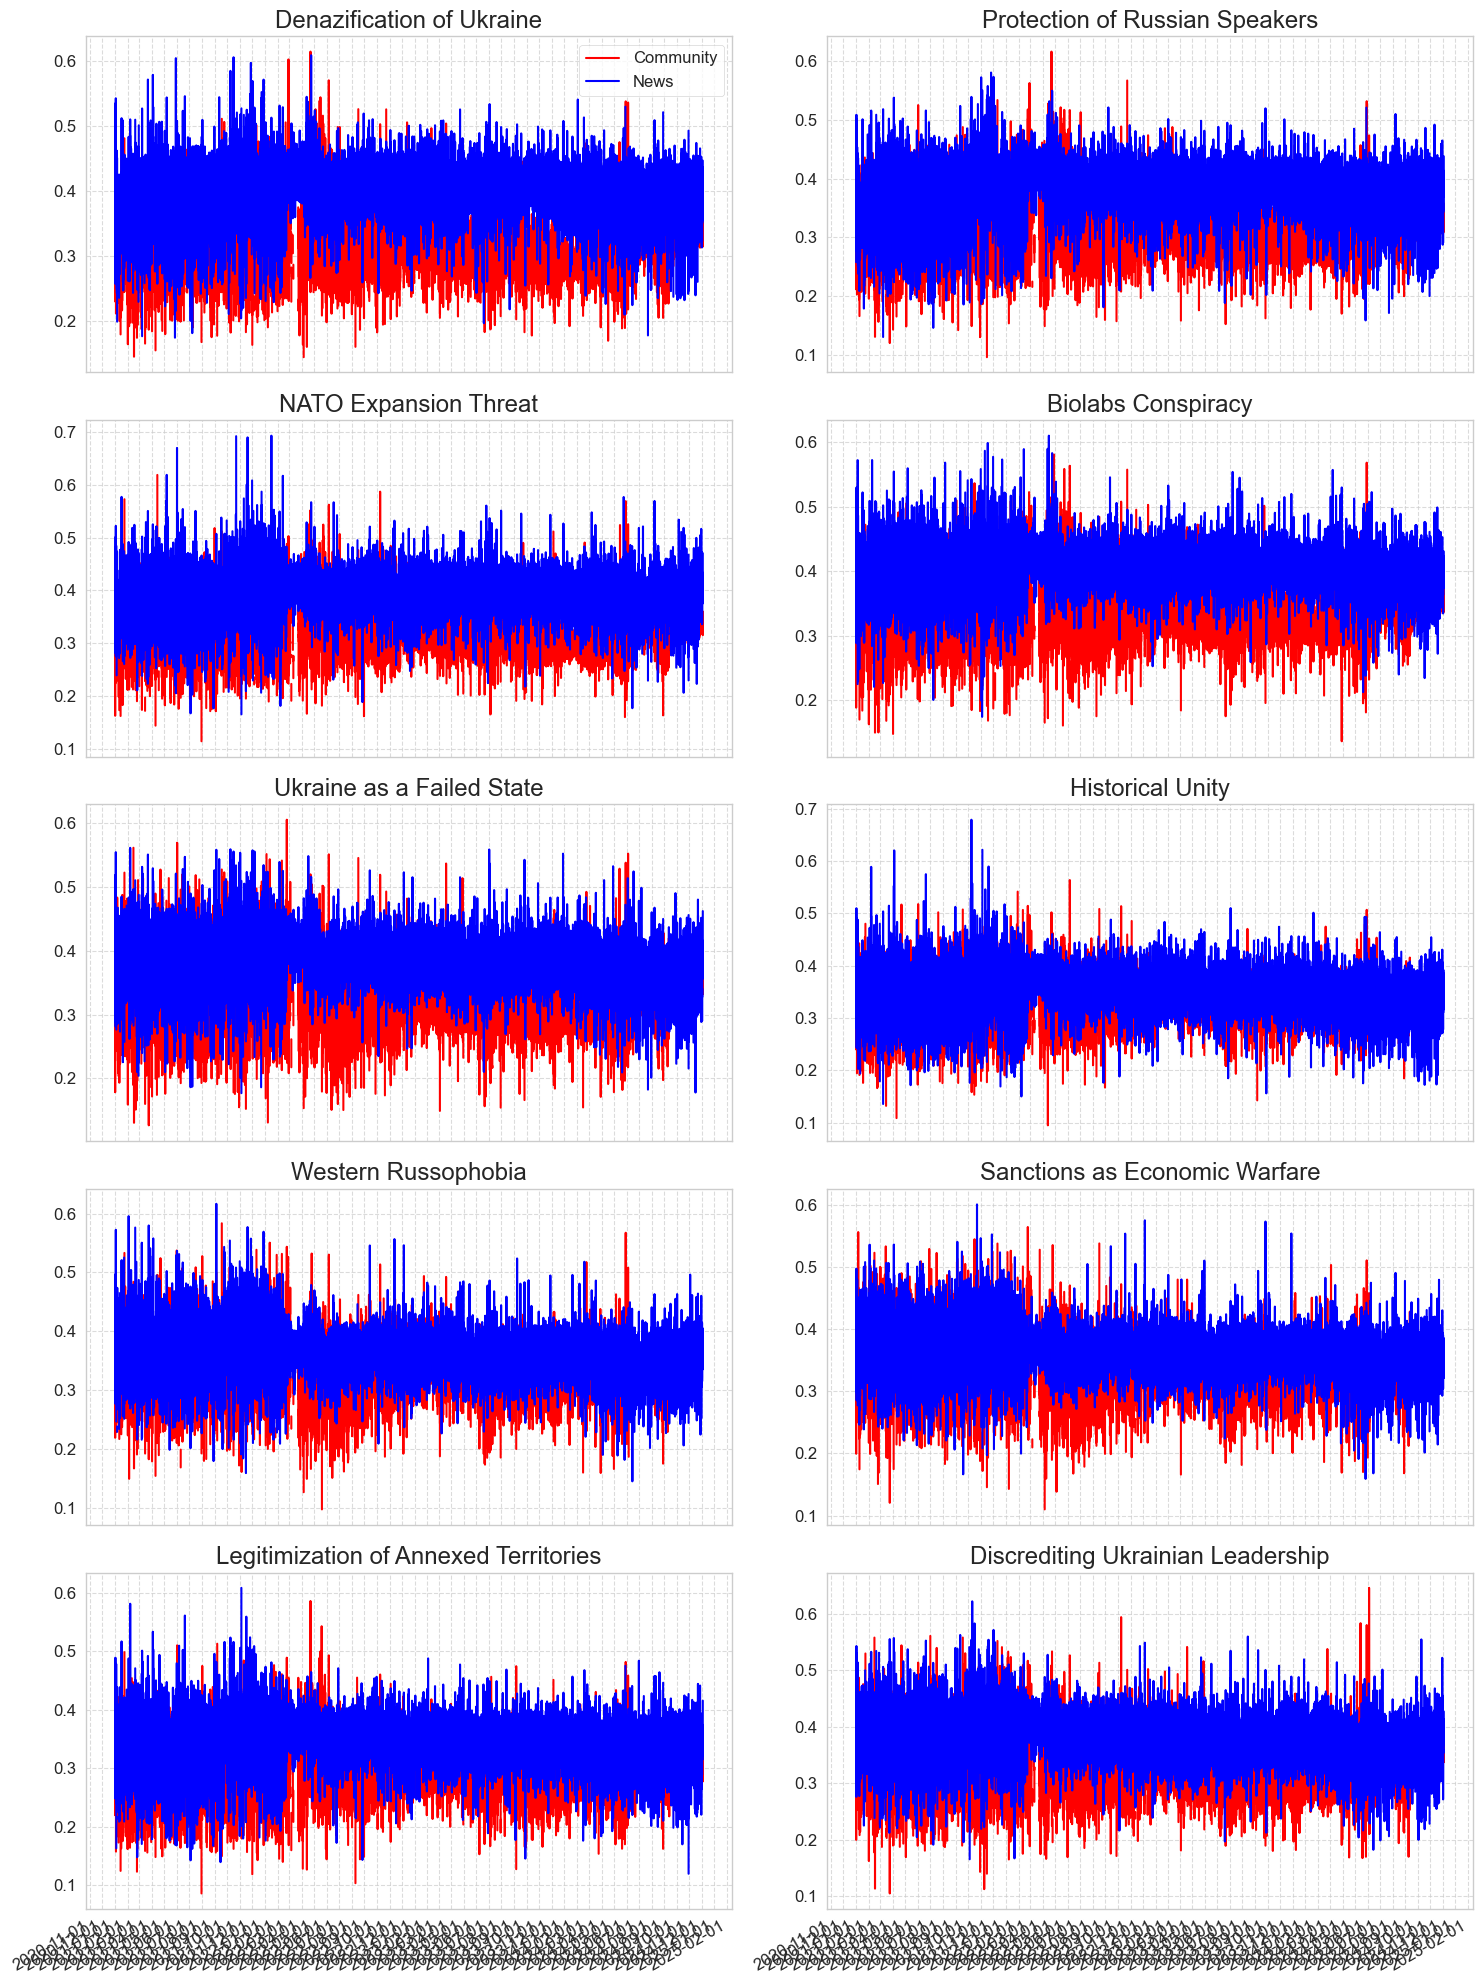

In [40]:
# Multi-narrative Time Series Analysis
import matplotlib.dates as mdates
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from collections import defaultdict
import matplotlib.ticker as ticker

# Calculate temporal density for all narratives
print("\nCalculating temporal density patterns for all narratives...")
densities = []
for narrative in NARRATIVE_COLUMNS:
    if narrative not in community_df.columns or narrative not in news_df.columns:
        print(f"Skipping {narrative} - not found in both datasets")
        continue
    
    # Calculate mean similarity score in 5-minute intervals
    community_density = community_df.resample('1H', on='messagedatetime')[narrative].mean()
    news_density = news_df.resample('1H', on='messagedatetime')[narrative].mean()
    
    # Store in list for later plotting
    densities.append({
        'narrative': narrative,
        'community': community_density,
        'news': news_density
    })

# Create multi-narrative visualization grid
if densities:
    # Calculate grid dimensions based on number of narratives
    n_narratives = len(densities)
    n_cols = 2  # Fixed at 2 columns
    n_rows = (n_narratives + 1) // 2  # Ceiling division
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4), sharex=True)
    axes = axes.flatten() if n_narratives > 1 else [axes]
    
    # Plot each narrative
    for i, density_data in enumerate(densities):
        if i >= len(axes):  # Safety check
            break
            
        narrative = density_data['narrative']
        display_name = NARRATIVE_DISPLAY_NAMES.get(narrative, narrative)
        
        # Get the data, aligned to common date range
        comm_data = density_data['community']
        news_data = density_data['news']
        
        # Determine common date range
        start_date = max(comm_data.index.min(), news_data.index.min())
        end_date = min(comm_data.index.max(), news_data.index.max())
        
        # Plot community and news lines
        axes[i].plot(comm_data.loc[start_date:end_date].index, 
                    comm_data.loc[start_date:end_date].values, 
                    'r-', linewidth=1.5, label='Community')
        axes[i].plot(news_data.loc[start_date:end_date].index, 
                    news_data.loc[start_date:end_date].values, 
                    'b-', linewidth=1.5, label='News')
        
        # Add title and formatting
        axes[i].set_title(display_name)
        axes[i].grid(True, linestyle='--', alpha=0.7)
        
        # Add legend on first plot only
        if i == 0:
            axes[i].legend()
    
    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    # Format x-axis dates
    fig.autofmt_xdate()
    for ax in axes[:i+1]:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        ax.xaxis.set_major_locator(mdates.MonthLocator())
    
    plt.tight_layout()
    plt.savefig('multi_narrative_temporal_patterns.png')
    plt.show()


Creating narrative strength heatmap...


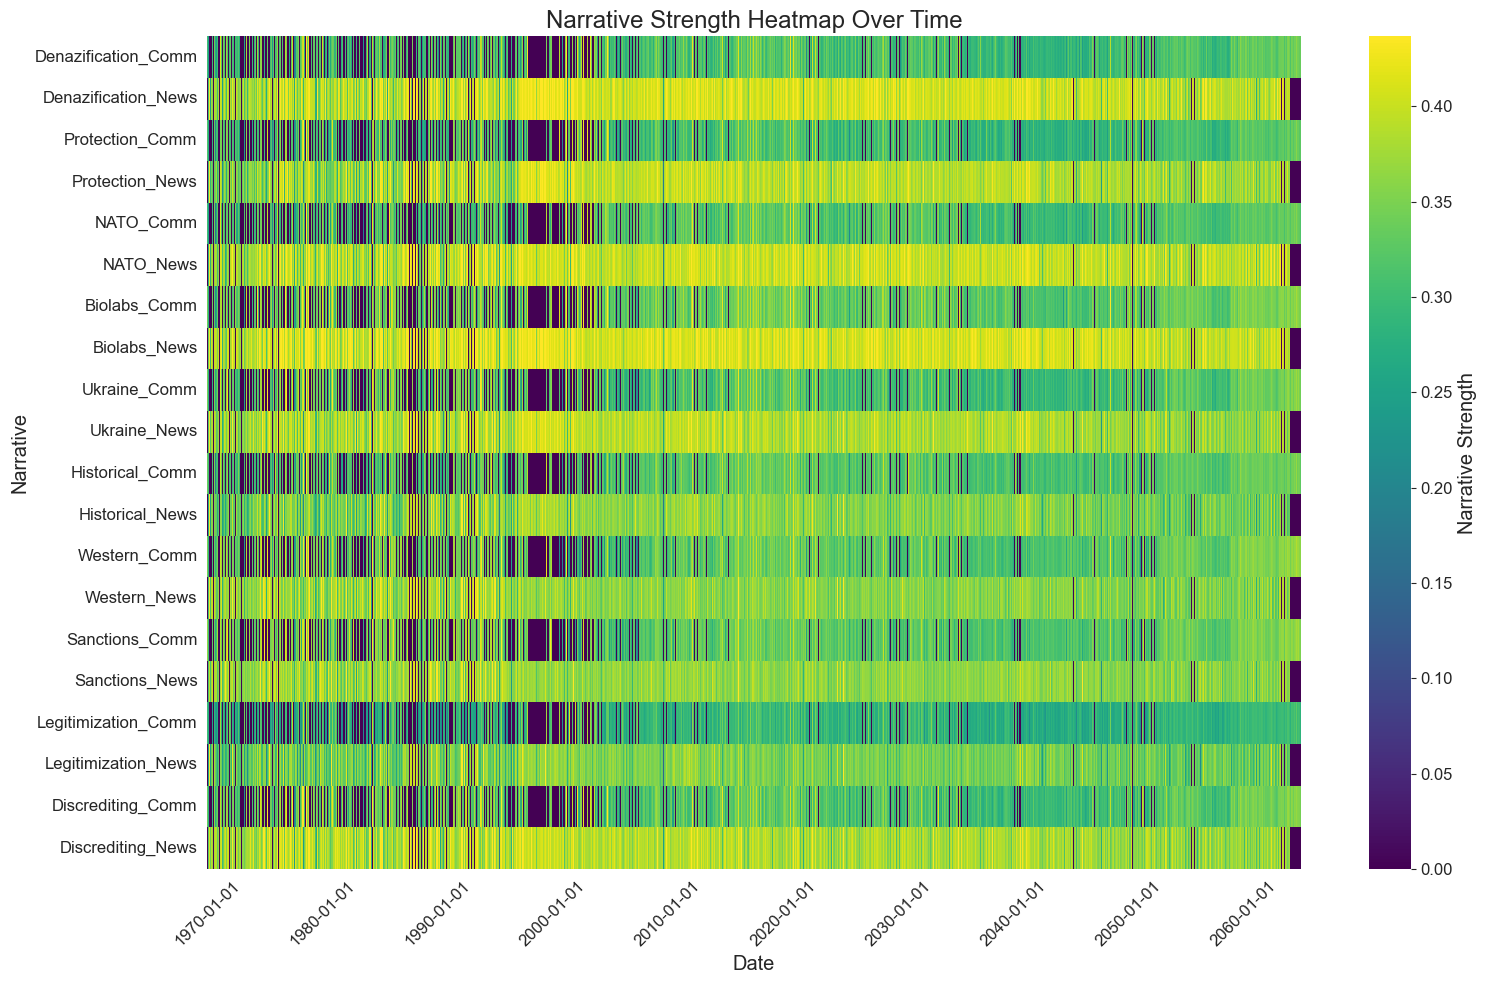

In [41]:
# Create Narrative Heatmap Visualization
# This cell creates a heatmap showing narrative strength over time

# Prepare data for heatmap
print("\nCreating narrative strength heatmap...")

# Combine densities into a single DataFrame for heatmap
all_narratives_data = {}

for density_data in densities:
    narrative = density_data['narrative']
    display_name = NARRATIVE_DISPLAY_NAMES.get(narrative, narrative).split()[0]  # Use first word for brevity
    
    # Combine community and news data with suffix
    community_data = density_data['community']
    news_data = density_data['news']
    
    all_narratives_data[f"{display_name}_Comm"] = community_data
    all_narratives_data[f"{display_name}_News"] = news_data

# Convert to DataFrame
all_data = pd.DataFrame(all_narratives_data)

# Get common time range where we have data for all narratives
start_date = all_data.index.min()
end_date = all_data.index.max()
all_data = all_data.loc[start_date:end_date]

# Fill NaN values with 0 for better visualization
all_data = all_data.fillna(0)

# Create heatmap
plt.figure(figsize=(16, 10))

# Customize colormap
cmap = sns.color_palette("viridis", as_cmap=True)

# Create the heatmap
heatmap = sns.heatmap(all_data.T, cmap=cmap, robust=True, 
                     cbar_kws={'label': 'Narrative Strength'})

# Format timestamp labels on x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Determine appropriate number of ticks based on date range
date_range = (all_data.index.max() - all_data.index.min()).days
n_ticks = min(date_range // 30, 12)  # Show roughly one tick per month, max 12
tick_locator = mdates.AutoDateLocator(minticks=n_ticks, maxticks=n_ticks+2)
ax.xaxis.set_major_locator(tick_locator)

plt.title("Narrative Strength Heatmap Over Time")
plt.xlabel("Date")
plt.ylabel("Narrative")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('narrative_strength_heatmap.png')
plt.show()

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from tqdm import tqdm

PROPAGANDA_THRESHOLD = 0.6

def analyze_thread_characteristics(community_df, threads, narrative_columns, threshold=PROPAGANDA_THRESHOLD):
    thread_metrics = []
    propaganda_thread_ids = set()

    print("Analyzing thread characteristics...")
    for thread_idx, thread in enumerate(tqdm(threads)):
        if not thread:
            continue

        root_message = thread[0]
        thread_id = f"{root_message['chat_id']}_{root_message['id']}"
        thread_size = len(thread)

        msg_depths = {root_message['id']: 0}
        max_depth = 0
        for msg in thread[1:]:
            reply_to = msg.get('reply_to')
            if reply_to in msg_depths:
                depth = msg_depths[reply_to] + 1
                msg_depths[msg['id']] = depth
                max_depth = max(max_depth, depth)

        if thread_size > 1:
            timestamps = [pd.to_datetime(msg['messagedatetime']) for msg in thread]
            duration_hours = (max(timestamps) - min(timestamps)).total_seconds() / 3600
        else:
            duration_hours = 0

        unique_participants = len(set(msg.get('from_id', 'unknown') for msg in thread))
        replies_per_hour = (thread_size - 1) / duration_hours if duration_hours > 0 else 0

        contains_propaganda = False
        propaganda_messages = 0
        for msg in thread:
            for narrative in narrative_columns:
                if narrative in msg and msg[narrative] > threshold:
                    contains_propaganda = True
                    propaganda_messages += 1
                    break

        if contains_propaganda:
            propaganda_thread_ids.add(thread_id)

        propaganda_percentage = (propaganda_messages / thread_size * 100) if thread_size > 0 else 0

        thread_metrics.append({
            'thread_id': thread_id,
            'thread_size': thread_size,
            'max_depth': max_depth,
            'duration_hours': duration_hours,
            'unique_participants': unique_participants,
            'replies_per_hour': replies_per_hour,
            'contains_propaganda': contains_propaganda,
            'propaganda_messages': propaganda_messages,
            'propaganda_percentage': propaganda_percentage
        })

    metrics_df = pd.DataFrame(thread_metrics)
    print(f"Analysis complete. Found {len(metrics_df)} threads, {len(propaganda_thread_ids)} with propaganda.")
    return metrics_df

def perform_statistical_comparison(metrics_df):
    propaganda_threads = metrics_df[metrics_df['contains_propaganda']]
    non_propaganda_threads = metrics_df[~metrics_df['contains_propaganda']]

    print("\n=== DESCRIPTIVE STATISTICS ===")
    print(f"Propaganda threads: {len(propaganda_threads)}")
    print(f"Non-propaganda threads: {len(non_propaganda_threads)}")

    comparison_metrics = [
        'thread_size',
        'max_depth',
        'duration_hours',
        'unique_participants',
        'replies_per_hour'
    ]

    print("\n=== COMPARISON OF MEANS ===")
    for metric in comparison_metrics:
        prop_mean = propaganda_threads[metric].mean()
        non_prop_mean = non_propaganda_threads[metric].mean()
        prop_median = propaganda_threads[metric].median()
        non_prop_median = non_propaganda_threads[metric].median()
        pct_diff = (prop_mean / non_prop_mean - 1) * 100 if non_prop_mean else 0

        print(f"\n{metric.replace('_', ' ').title()}:")
        print(f"  Propaganda threads: mean={prop_mean:.2f}, median={prop_median:.2f}")
        print(f"  Non-propaganda threads: mean={non_prop_mean:.2f}, median={non_prop_median:.2f}")
        print(f"  Difference: {prop_mean - non_prop_mean:.2f} ({pct_diff:.1f}%)")

    print("\n=== STATISTICAL SIGNIFICANCE ===")
    for metric in comparison_metrics:
        _, p1 = stats.shapiro(propaganda_threads[metric])
        _, p2 = stats.shapiro(non_propaganda_threads[metric])
        is_normal = p1 > 0.05 and p2 > 0.05

        if is_normal:
            stat, p_value = stats.ttest_ind(propaganda_threads[metric], non_propaganda_threads[metric], equal_var=False)
            test_name = "Welch's t-test"
        else:
            stat, p_value = stats.mannwhitneyu(propaganda_threads[metric], non_propaganda_threads[metric])
            test_name = "Mann-Whitney U test"

        direction = "Propaganda > Non-propaganda" if propaganda_threads[metric].mean() > non_propaganda_threads[metric].mean() else "Non-propaganda > Propaganda"
        print(f"\n{metric.replace('_', ' ').title()} ({test_name}):")
        print(f"  p-value: {p_value:.6f}")
        print(f"  Statistically significant: {'Yes' if p_value < 0.05 else 'No'}")
        print(f"  Effect direction: {direction}")

    return propaganda_threads, non_propaganda_threads

def visualize_comparison(propaganda_threads, non_propaganda_threads):
    comparison_metrics = [
        'thread_size',
        'max_depth',
        'duration_hours',
        'unique_participants',
        'replies_per_hour'
    ]

    plot_data = pd.concat([
        propaganda_threads[comparison_metrics + ['contains_propaganda']],
        non_propaganda_threads[comparison_metrics + ['contains_propaganda']]
    ])

    for metric in comparison_metrics:
        plt.figure(figsize=(10, 6))

        ax = sns.violinplot(
            x='contains_propaganda', y=metric, data=plot_data,
            inner='quartile', palette={True: 'red', False: 'blue'}
        )

        sns.boxplot(
            x='contains_propaganda', y=metric, data=plot_data,
            width=0.2, color='white', ax=ax
        )

        sns.stripplot(
            x='contains_propaganda', y=metric, data=plot_data,
            alpha=0.3, jitter=True, ax=ax
        )

        plt.title(f'Distribution of {metric.replace("_", " ").title()}\nPropaganda vs. Non-propaganda Threads')
        plt.xlabel('Contains Propaganda')
        plt.ylabel(metric.replace('_', ' ').title())
        plt.xticks([0, 1], ['No', 'Yes'])

        plt.axhline(y=propaganda_threads[metric].mean(), color='red', linestyle='--',
                    label=f'Propaganda Mean: {propaganda_threads[metric].mean():.2f}')
        plt.axhline(y=non_propaganda_threads[metric].mean(), color='blue', linestyle='--',
                    label=f'Non-propaganda Mean: {non_propaganda_threads[metric].mean():.2f}')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'comparison_{metric}.png')
        plt.show()

    plt.figure(figsize=(10, 8))
    corr_matrix = propaganda_threads[comparison_metrics].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation between Metrics in Propaganda Threads')
    plt.tight_layout()
    plt.savefig('propaganda_correlation_heatmap.png')
    plt.show()

def print_percentile_comparison(propaganda_col, non_propaganda_col, metric_name):
    percentiles = [10, 25, 50, 75, 90, 95, 99]
    print(f"\n{metric_name} Percentile Comparison:")
    print(f"{'Percentile':>10} | {'Propaganda':>10} | {'Non-propaganda':>15} | {'Ratio':>8}")
    print("-" * 60)
    for p in percentiles:
        prop_val = np.percentile(propaganda_col, p)
        non_prop_val = np.percentile(non_propaganda_col, p)
        ratio = prop_val / non_prop_val if non_prop_val > 0 else float('inf')
        print(f"{p:>10}% | {prop_val:>10.2f} | {non_prop_val:>15.2f} | {ratio:>8.2f}x")

# Execution
metrics_df = analyze_thread_characteristics(community_df, threads, narrative_columns)
propaganda_threads, non_propaganda_threads = perform_statistical_comparison(metrics_df)
visualize_comparison(propaganda_threads, non_propaganda_threads)

print("\n=== ADDITIONAL INSIGHTS ===")

plt.figure(figsize=(12, 6))
plt.hist(
    [propaganda_threads['thread_size'], non_propaganda_threads['thread_size']],
    bins=30, alpha=0.7, label=['Propaganda', 'Non-propaganda'], density=True
)
plt.axvline(propaganda_threads['thread_size'].mean(), color='red', linestyle='--',
            label=f'Propaganda Mean: {propaganda_threads["thread_size"].mean():.2f}')
plt.axvline(non_propaganda_threads['thread_size'].mean(), color='blue', linestyle='--',
            label=f'Non-propaganda Mean: {non_propaganda_threads["thread_size"].mean():.2f}')
plt.xlabel('Thread Size (number of messages)')
plt.ylabel('Density')
plt.title('Thread Size Distribution: Propaganda vs. Non-propaganda')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('thread_size_distribution.png')
plt.show()

for metric in [
    'thread_size',
    'max_depth',
    'duration_hours',
    'unique_participants',
    'replies_per_hour'
]:
    print_percentile_comparison(
        propaganda_threads[metric].values,
        non_propaganda_threads[metric].values,
        metric.replace('_', ' ').title()
    )


NameError: name 'threads' is not defined